In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
import regex as re
import warnings
from os import path
from PIL import Image
import matplotlib.pyplot as plt


from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [4]:
def clean_dataset_col(dataset, col):
    
    tokenizer = RegexpTokenizer(r'\s+', gaps=True)
    
    for i in range(len(dataset[col])):

        # Remove Punctuation in the texts
        # Substitute those that are not Alphabets or Numbers into " "
        dataset[col][i] = re.sub("[^a-zA-Z0-9']", " ", string = dataset[col][i])

        # Remove all poker/blackjack from 'text' columns
        dataset[col][i] = dataset[col][i].lower().replace('republicans', '').replace('democrats', '')

        # Tokenize DataFrame
        dataset[col][i] = tokenizer.tokenize(dataset[col][i])
        
        # Remove StopWords
        dataset[col][i] = [words for words in dataset[col][i] if words not in stopwords.words('english')]

In [5]:
# Lemmatize each word in each text column the join each word back into a sentence
def lemmatize_join(lem_data, col):
    for i in range(len(lem_data[col])):
        lem_data[col][i] = [lemmatizer.lemmatize(word) for word in lem_data[col][i]] # Lemmatize each word in the row
        lem_data[col][i] = ' '.join(lem_data[col][i]) # Join the words back into a string

In [9]:
# Stem each word in each text column the join each word back into a sentence
def stem_join(stem_data, col):
    for i in range(len(stem_data[col])):
        stem_data[col][i] = [p_stemmer.stem(word) for word in stem_data[col][i]] # Stem each word in the row
        stem_data[col][i] = ' '.join(stem_data[col][i]) # Join the word back into a string
        
def roc(probas, true, step=0.01):    
    probas = probas[:,1]  # The output of predict_proba() is an array of the probabilities for every class, but we only want the probabilities for class 1
    true = true.values    # We need to convert the class labels from a Pandas Series to a numpy array. We do this using the .values attribute
    assert(len(probas) == len(true)) # We're making sure that our probabilities vector is the same length as our true class labesl vector
    
    TPRs = [] # Setting up empty list of True Positive Rate
    FPRs = [] # Setting up empty list of False Positive Rate
    
    for i in np.arange(0.0,1.0,step): # np.arange allows us to use step sizes that are decimals
        preds_class = probas > i # Numpy arrays have a feature called 'broadcasting.' Check the documentation: https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html to see what this does.
        TP = 0  # TP = True Positive
        FP = 0  # FP = False Positive
        TN = 0  # TN = True Negative
        FN = 0  # FN = False Negative
        for index in range(len(preds_class)): # We're comparing each prediction with each true value here

            if preds_class[index] == 1 and true[index] == 1:
                TP += 1
            elif preds_class[index] == 1 and true[index] == 0:
                FP += 1
            elif preds_class[index] == 0 and true[index] == 0:
                TN += 1 
            elif preds_class[index] == 0 and true[index] == 1:
                FN += 1
                
        TPR = TP/(TP + FN) # Calculating TPR and FPR and appending to our lists
        FPR = FP/(FP + TN)
        
        TPRs.append(TPR)
        FPRs.append(FPR)
         
    plt.rcParams['font.size'] = 12
    plt.plot(FPRs, TPRs, color="orange")
    plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.2, 1.2])
    plt.ylim([-0.2, 1.2])
    plt.title('Receiver Operating Characteristic')
    plt.xlabel("False Positive Rate (1 - Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.show();

In [10]:
df_dem = pd.read_csv('./dems.csv')
df_dem.shape

(844, 3)

In [11]:
df_rep = pd.read_csv('./reps.csv')
df_rep.shape

(600, 3)

In [12]:
df_dem = pd.melt(df_dem ,id_vars = 'subreddit')

In [14]:
df_dem = df_dem[['subreddit','value']]
df_dem.rename(columns = {'value': 'text'}, inplace=True)

In [15]:
df_rep = pd.melt(df_rep ,id_vars = 'subreddit')

In [16]:
df_rep = df_rep[['subreddit','value']]
df_rep.rename(columns = {'value': 'text'}, inplace=True)

In [17]:
master_df = pd.concat([df_dem, df_rep]).reset_index(drop=True)

In [18]:
master_df.head()

,subreddit,text
0,democrats,Hillary Clinton: Richard Nixon once made this ...
1,democrats,Team Trump Trips Over GOP Questions About Fact...
2,democrats,Pelosi Suggests Trump’s Lawyers Should Be Disb...
3,democrats,Wanna know what happens when we show up to vot...
4,democrats,"Give it up, media cowards — there's no way to ..."


In [19]:
master_df.isnull().sum()

subreddit       0
text         1365
dtype: int64

In [20]:
master_df.dropna(inplace=True)

In [21]:
master_df = master_df.reset_index(drop=True)

In [22]:
# Check Number of observations for each subreddit
master_df.iloc[:,0].value_counts(normalize = True)

democrats      0.606041
republicans    0.393959
Name: subreddit, dtype: float64

The number of observations for each subreddit is not really balanced. The Baseline accuracy for republicans is 0.39..

In [23]:
master_df['text'] = master_df['text'].replace('\n', '', regex=True).replace('/r/','',regex=True)
master_df.head()

,subreddit,text
0,democrats,Hillary Clinton: Richard Nixon once made this ...
1,democrats,Team Trump Trips Over GOP Questions About Fact...
2,democrats,Pelosi Suggests Trump’s Lawyers Should Be Disb...
3,democrats,Wanna know what happens when we show up to vot...
4,democrats,"Give it up, media cowards — there's no way to ..."


In [24]:
clean_dataset_col(dataset = master_df, col = 'text')

In [25]:
# Create a Dataframe for republicans wordcloud
rep_wc = master_df[master_df['subreddit']=='republicans']

In [26]:
dem_wc = master_df[master_df['subreddit']=='democrats']

In [29]:
pip install wordcloud

     |████████████████████████████████| 163kB 2.5MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [30]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [32]:
# Plot WordCloud
def wordcloud(data, title = None):
    # Create a string containing words from every row
    string = ""
    
    for row in data: # Iterate through each row 
        for word in row: # Iterate through each word in the row
            string = string + str(word) + ' ' # Combine each word into a string
    string = re.sub("[^a-zA-Z0-9']", " ",string = string) # Use regex to remove unwanted symbols and stuff
    
    
    wordcloud = WordCloud( # WordCloud creation
        background_color='white',
        max_words=100,
        max_font_size=40,
        scale=3,
    ).generate(str(string))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

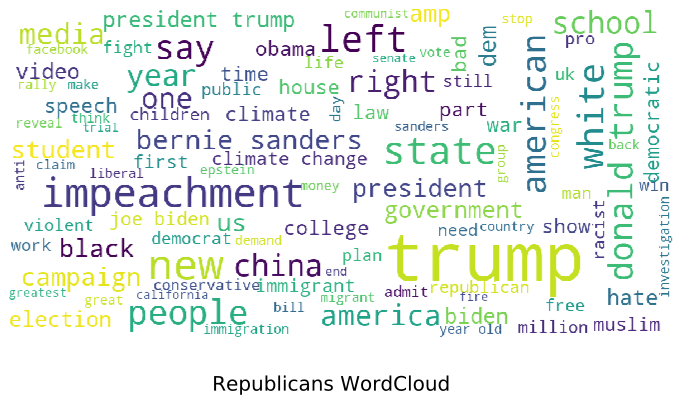

In [33]:
wordcloud(rep_wc['text'], title = 'Republicans WordCloud')

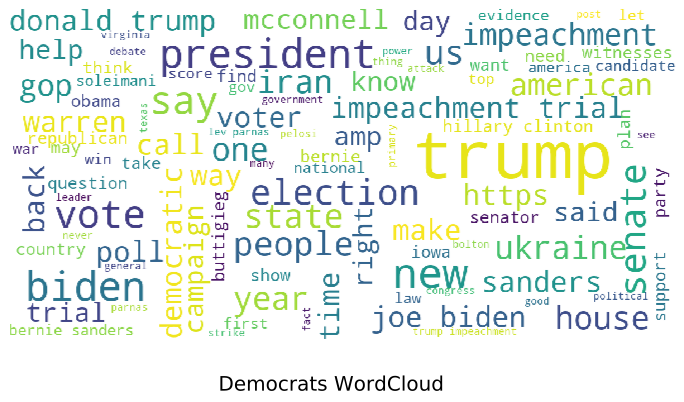

In [34]:
wordcloud(dem_wc['text'], title = 'Democrats WordCloud')

In [35]:
# Create dataframe for lemmatization and stemming seperately
lem_df = master_df.copy()

In [36]:
# Instantiate Lemmatizer
lemmatizer = WordNetLemmatizer()
# Lemmatize the column
lemmatize_join(lem_df, col = "text")

All models yielded a high training score (above baseline of 53%) yet were overfit. Probably would not perform so well on other datasets.
My LR model yielded a training/test score of 96% and 74% with stopwords. Removing stopwords yielded 80% and 68%.
Random Forest model yielded a training/test score of 77% and 69% with stopwords. Removing stopwords yielded a 61% and 57%. (Lowest performing model but least overfit) This was interesting because decision trees usually are very overfit.
Gaussian Naive Bayes model yielded a training/test score of 86% and 63% with stopwords. Removing stopwords yielded scores of 92% and 77%.

In [37]:
# Mapping each subreddit into binary
lem_df['target'] = lem_df['subreddit'].map({'republicans': 0, 'democrats': 1})

In [38]:
# Create Predictors and Target Variable
X = lem_df['text']
y = lem_df['target']

In [39]:
# Split data into Model Evaluation Dataset(set) and Test Dataset(test)
X_set, X_test, y_set, y_test = train_test_split(X, y, stratify=y, random_state=34, test_size = 0.2)

In [40]:
# Split Model Evaluation Dataset into train and evaluation set
X_train, X_eval, y_train, y_eval = train_test_split(X_set, y_set, stratify=y_set, random_state=34, test_size = 0.25)

In [41]:
print(X_train.shape)
print(X_eval.shape)

(913,)
(305,)


In [42]:
logpipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('logreg', LogisticRegression())
])

In [43]:
logpipe2 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logreg', LogisticRegression())
])

In [44]:
params = {
    'cvec__max_features': [500,1000,2000,3000,4000,4500,5000],
    'cvec__min_df': [2,3],
    'cvec__max_df': [0.9, 0.95],
    'cvec__ngram_range': [(1,1),(1,2),(1,3)]
}

In [45]:
# Parameters for Logpipe2
params_2 = {
    'tfidf__max_features': [500,1000,2000,3000,4000,4500,5000],
    'tfidf__min_df': [2,3],
    'tfidf__max_df': [0.9, 0.95],
    'tfidf__ngram_range': [(1,1),(1,2),(1,3)]
}

In [46]:
# Best Parameters for Logpipe
gs_log = GridSearchCV(logpipe, param_grid = params, cv = 5)
gs_log.fit(X_train, y_train)
print("Best Accuracy: " + str(gs_log.best_score_))
print("Best Parameters: ")
gs_log.best_params_

/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: Futur

/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: Futur

/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: Futur

/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: Futur

/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: Futur

/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: Futur

/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: Futur

/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: Futur

/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: Futur

/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: Futur

/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: Futur

Best Accuracy: 0.732749178532311
Best Parameters: 


/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


{'cvec__max_df': 0.9,
 'cvec__max_features': 2000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 3)}

Best Accuracy: 0.732749178532311
Best Parameters: 
{'cvec__max_df': 0.9,
 'cvec__max_features': 2000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 3)}

In [47]:
# Best Parameters for Logpipe2
gs_log_2 = GridSearchCV(logpipe2, param_grid = params_2, cv = 5)
gs_log_2.fit(X_train, y_train)
print("Best Accuracy: " + str(gs_log_2.best_score_))
print("Best Parameters: ")
gs_log_2.best_params_

/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: Futur

/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: Futur

/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: Futur

/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: Futur

/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: Futur

/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: Futur

/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: Futur

/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: Futur

/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: Futur

/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: Futur

/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: Futur

Best Accuracy: 0.7031763417305587
Best Parameters: 


{'tfidf__max_df': 0.9,
 'tfidf__max_features': 500,
 'tfidf__min_df': 3,
 'tfidf__ngram_range': (1, 2)}

Best Accuracy: 0.7031763417305587
Best Parameters: 
{'tfidf__max_df': 0.9,
 'tfidf__max_features': 500,
 'tfidf__min_df': 3,
 'tfidf__ngram_range': (1, 2)}

Since TFIDF Vectorizer produced better accuracy with Best Accuracy: 0.733 compared to CountVectorier with Best Accuracy: 0.703, we shall perform TFIDF Vectorizer on the model.

In [48]:
#Instantiate TfidfVectorizer with Best parameters
tv = TfidfVectorizer(max_df = 0.9, max_features = 3000, min_df = 2, ngram_range = (1,1))

In [49]:
# Fit our TfidfVectorizer on the training data and transform training data.
X_train_tv = pd.DataFrame(tv.fit_transform(X_train).todense(),
                          columns = tv.get_feature_names())

In [50]:
# Transform our testing data with the already-fit TfidfVectorizer.
X_eval_tv = pd.DataFrame(tv.transform(X_eval).todense(),
                         columns = tv.get_feature_names())

In [51]:
# Fit Model into LogisticRegression
logreg = LogisticRegression()
log_model = logreg.fit(X_train_tv,y_train)

/Users/gabriellechases/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [52]:
# Score of training set
print('Accuracy of Training Set = ' + str(log_model.score(X_train_tv, y_train)))
# Score of Testing Set
print('Accuracy of Evaluation Set = ' + str(log_model.score(X_eval_tv, y_eval)))

Accuracy of Training Set = 0.9090909090909091
Accuracy of Evaluation Set = 0.7147540983606557


In [53]:
# Pipeline Using Count Vectorizer
nbpipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('logreg', MultinomialNB())
])

In [54]:
# Pipeline using TFIDF Vectorizer
nbpipe2 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logreg', MultinomialNB())
])

In [55]:
# Best Parameters for nbpipe
gs_nb = GridSearchCV(nbpipe, param_grid = params, cv = 5)
gs_nb.fit(X_train, y_train)
print("Best Accuracy: " + str(gs_nb.best_score_))
print("Best Parameters: ")
gs_nb.best_params_

Best Accuracy: 0.7064622124863089
Best Parameters: 


{'cvec__max_df': 0.9,
 'cvec__max_features': 2000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2)}

In [56]:
# Best Parameters for nbpipe2
gs_nb_2 = GridSearchCV(nbpipe2, param_grid = params_2, cv = 5)
gs_nb_2.fit(X_train, y_train)
print("Best Accuracy: " + str(gs_nb_2.best_score_))
print("Best Parameters: ")
gs_nb_2.best_params_

Best Accuracy: 0.7075575027382256
Best Parameters: 


{'tfidf__max_df': 0.9,
 'tfidf__max_features': 2000,
 'tfidf__min_df': 2,
 'tfidf__ngram_range': (1, 1)}

Since Count Vectorizer produced better accuracy with Best Accuracy: 0.70 while the TFIDF Vectorizer produced an accuracy of Best Accuracy: 0.70, we shall perform Count Vectorizer on the model.

In [57]:
# Instantiate CountVectorizer with Best parameters
cvec = CountVectorizer(max_df = 0.9, max_features = 3000, min_df = 2, ngram_range = (1,2))

In [58]:
# Fit our CountVectorizer on the training data and transform training data.
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train).todense(),
                          columns = cvec.get_feature_names())

In [59]:
# Transform our Eval data with the already-fit CountVectorizer.
X_eval_cvec = pd.DataFrame(cvec.transform(X_eval).todense(),
                         columns = cvec.get_feature_names())

In [60]:
# Fit Model into MultiNominalNB
nb = MultinomialNB()
nb_model = nb.fit(X_train_cvec,y_train)

In [61]:
# Score of training set
print('Accuracy of Training Set = ' + str(nb_model.score(X_train_cvec, y_train)))
# Score of Testing set
print('Accuracy of Evaluation Set = ' + str(nb_model.score(X_eval_cvec, y_eval)))

Accuracy of Training Set = 0.9145673603504929
Accuracy of Evaluation Set = 0.7311475409836066


In [62]:
# Instantiate CountVectorizer with Best parameters
cvec = CountVectorizer(max_df = 0.9, max_features = 3000, min_df = 2, ngram_range = (1,2))

In [63]:
# Fit our CountVectorizer on the training data and transform training data.
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train).todense(),
                          columns = cvec.get_feature_names())

In [64]:
# Transform our Eval data with the already-fit CountVectorizer.
X_eval_cvec = pd.DataFrame(cvec.transform(X_eval).todense(),
                         columns = cvec.get_feature_names())

In [65]:
# Fit Model into MultiNominalNB
nb = MultinomialNB()
nb_model = nb.fit(X_train_cvec,y_train)

In [66]:
# Score of training set
print('Accuracy of Training Set = ' + str(nb_model.score(X_train_cvec, y_train)))
# Score of Testing set
print('Accuracy of Evaluation Set = ' + str(nb_model.score(X_eval_cvec, y_eval)))

Accuracy of Training Set = 0.9145673603504929
Accuracy of Evaluation Set = 0.7311475409836066


In [67]:
# Pipeline Using Count Vectorizer
rfpipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier(n_jobs= -1))
])
# Pipeline using TFIDF Vectorizer
rfpipe2 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rf', RandomForestClassifier(n_jobs=-1))
])

In [68]:
# Parameters for dtpipe
params_rf = {
    'cvec__max_features': [4000,5000],
    'cvec__min_df': [6,15],
    'cvec__max_df': [0.9, 0.95],
    'cvec__ngram_range': [(1,1),(1,2)],
    'rf__n_estimators': [200,300],
    'rf__max_depth': [20,40]
}

# Parameters for dtpipe2
params_rf2 = {
    'tfidf__max_features': [4000,5000],
    'tfidf__min_df': [10,15],
    'tfidf__max_df': [0.9,0.95],
    'tfidf__ngram_range': [(1,1),(1,2)],
    'rf__n_estimators': [50,100],
    'rf__max_depth': [50,75]
}

In [69]:
# Best Parameters for nbpipe
gs_rf = GridSearchCV(rfpipe, param_grid = params_rf, cv = 5)
gs_rf.fit(X_train, y_train)
print("Best Accuracy: " + str(gs_rf.best_score_))
print("Best Parameters: ")
gs_rf.best_params_

Best Accuracy: 0.7360350492880613
Best Parameters: 


{'cvec__max_df': 0.9,
 'cvec__max_features': 4000,
 'cvec__min_df': 6,
 'cvec__ngram_range': (1, 1),
 'rf__max_depth': 20,
 'rf__n_estimators': 200}

In [70]:
# Best Parameters for nbpipe2
gs_rf_2 = GridSearchCV(rfpipe2, param_grid = params_rf2, cv = 5)
gs_rf_2.fit(X_train, y_train)
print("Best Accuracy: " + str(gs_rf_2.best_score_))
print("Best Parameters: ")
gs_rf_2.best_params_

Best Accuracy: 0.7447973713033954
Best Parameters: 


{'rf__max_depth': 50,
 'rf__n_estimators': 50,
 'tfidf__max_df': 0.95,
 'tfidf__max_features': 4000,
 'tfidf__min_df': 10,
 'tfidf__ngram_range': (1, 2)}

In [71]:
# Instantiate CountVectorizer with Best parameters
cvec_rf = CountVectorizer(max_df = 0.95, max_features = 5000, min_df = 6, ngram_range = (1,2))
# Instantiate CountVectorizer with Best parameters
rf = RandomForestClassifier(max_depth = 20, n_estimators = 300,n_jobs= -1)

In [72]:
# Fit our CountVectorizer on the training data and transform training data.
X_train_cvec_rf = pd.DataFrame(cvec_rf.fit_transform(X_train).todense(),
                          columns = cvec_rf.get_feature_names())

In [73]:
# Transform our testing data with the already-fit CountVectorizer.
X_eval_cvec_rf = pd.DataFrame(cvec_rf.transform(X_eval).todense(),
                         columns = cvec_rf.get_feature_names())

In [74]:
# Fit Model into MultiNominalNB
rf_model = rf.fit(X_train_cvec_rf,y_train)

In [75]:
# Score of training set
print('Accuracy of Training Set = ' + str(rf_model.score(X_train_cvec_rf, y_train)))
# Score of Testing set
print('Accuracy of Evaluation Set = ' + str(rf_model.score(X_eval_cvec_rf, y_eval)))

Accuracy of Training Set = 0.8882803943044907
Accuracy of Evaluation Set = 0.7672131147540984


In [76]:
# Score of Naive Bayes training set
print('Accuracy of Naive Bayes Training Set = ' + str(nb_model.score(X_train_cvec, y_train)))
# Score of Naive Bayes eval set
print('Accuracy of Naive Bayes Evaluation Set = ' + str(nb_model.score(X_eval_cvec, y_eval)))
# Score of LogRes training set
print('Accuracy of LogRes Training Set = ' + str(log_model.score(X_train_tv, y_train)))
# Score of LogRes eval Set
print('Accuracy of LogRes Evaluation Set = ' + str(log_model.score(X_eval_tv, y_eval)))
# Score of RandomForest training set
print('Accuracy of RandomForest Training Set = ' + str(rf_model.score(X_train_cvec_rf, y_train)))
# Score of RandomForest Testing set
print('Accuracy of RandomForest Evaluation Set = ' + str(rf_model.score(X_eval_cvec_rf, y_eval)))

Accuracy of Naive Bayes Training Set = 0.9145673603504929
Accuracy of Naive Bayes Evaluation Set = 0.7311475409836066
Accuracy of LogRes Training Set = 0.9090909090909091
Accuracy of LogRes Evaluation Set = 0.7147540983606557
Accuracy of RandomForest Training Set = 0.8882803943044907
Accuracy of RandomForest Evaluation Set = 0.7672131147540984


In [78]:
# Transform our testing data with the already-fit CountVectorizer.
X_test_cvec = pd.DataFrame(cvec.transform(X_test).todense(),
                         columns = cvec.get_feature_names())

In [80]:
X_set_cvec = pd.DataFrame(cvec.fit_transform(X_set).todense(),
                          columns = cvec.get_feature_names())

In [79]:
# Fit the Training set into MultiNominalNB
nb = MultinomialNB() # Set prior probabilities of each class [blackjack proba, poker proba]
nb_model = nb.fit(X_set_cvec,y_set)

In [81]:
# Score of training set
print('Accuracy of Training Set = ' + str(nb_model.score(X_set_cvec, y_set)))
# Score of Testing set
print('Accuracy of Testing Set = ' + str(nb_model.score(X_test_cvec, y_test)))# Fit our CountVectorizer on the training data and transform training data.


Accuracy of Training Set = 0.909688013136289
Accuracy of Testing Set = 0.7442622950819672


In [82]:
# Predict the subreddits from the test data
nb_pred = nb_model.predict(X_test_cvec)

In [83]:
# Generate Confusion Matrix
confusion_matrix(y_test, nb_pred)

array([[ 65,  55],
       [ 23, 162]])

In [84]:
tn, fp, fn, tp = confusion_matrix(y_test, nb_pred).ravel()
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 65
False Positives: 55
False Negatives: 23
True Positives: 162


The confusion matrix shows True Positives(tp), True Negatices(tn), False Positives(fp), False Negatives(np).

tp = the model guessing the subreddit is dems and got it correct.
tn = the model guessing the subreddit is reps and got it correct.
fp = the model guessing the subreddit is dems but rather is reps.
fn = the model guessing the subreddit is reps but rather is dems.

In [85]:
# Let's create a dataframe called pred_df that contains:
# 1. The list of true values of our test set.
# 2. The list of predicted probabilities based on our model.

pred_proba = [i[1] for i in nb_model.predict_proba(X_test_cvec)] 
# i[1] = probability of predicting True Positive
# if i[1] > 0.5 = Dead

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})
pred_df.head()

,true_values,pred_probs
207,1,0.979944
143,1,0.973001
816,1,0.992195
981,0,0.003818
867,1,0.999992


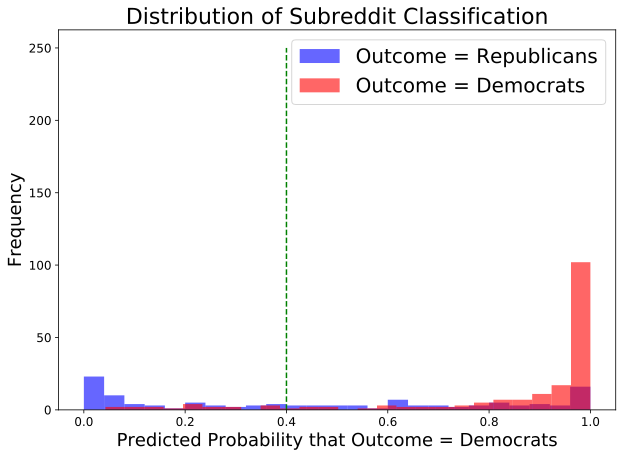

In [106]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Outcome = Republicans')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='r',
         alpha = 0.6,
         label='Outcome = Democrats')

# Add vertical line at P(Outcome = 1) = 0.6.
plt.vlines(x=0.4,
           ymin = 0,
           ymax = 250,
           color='g',
           linestyle = '--')

# Label axes.
plt.title('Distribution of Subreddit Classification', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = Democrats', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

In [87]:
# generate classification report
print(classification_report(y_test, nb_pred))

              precision    recall  f1-score   support

           0       0.74      0.54      0.62       120
           1       0.75      0.88      0.81       185

    accuracy                           0.74       305
   macro avg       0.74      0.71      0.72       305
weighted avg       0.74      0.74      0.73       305



In [88]:
# Probabilities
probabilities = nb_model.predict_proba(X_test_cvec)

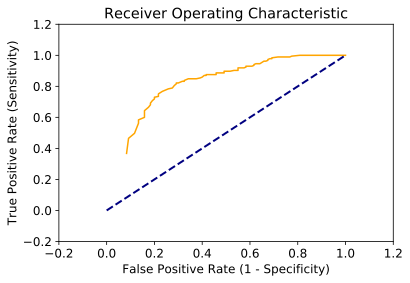

In [89]:
# Plot ROC Curve
roc(probabilities, y_test, step = 0.01)

In [90]:
# Calculate the Area Under Curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, nb_pred)
print('Area Under ROC Curve(AUC): ' + str(metrics.auc(fpr, tpr)))

Area Under ROC Curve(AUC): 0.7086711711711712


In a ROC curve the true positive rate (Sensitivity) is plotted in function of the false positive rate (100-Specificity) for different cut-off points of a parameter. Each point on the ROC curve represents a sensitivity/specificity pair corresponding to a particular decision threshold. The area under the ROC curve (AUC) is a measure of how well a parameter can distinguish between two diagnostic groups (Dems/Reps).

The higher the AUC, the better the model is. When perfect scenario would be a score of 1, which would mean the yellow line in the graph above you be a right angled triangle. The AUC of our model is 0.709, which would explain the slight curve in the graph. A score of 0.709 is sorta average.

In [91]:
# Create Dataframe with y_test values and X_test Values 
combined_df = pd.concat([y_test.to_frame().reset_index(drop=True),X_test_cvec], axis=1)

In [103]:
# Split dataset into 1 = dems and 0 = reps according to 'target'
#dems = combined_df[combined_df['target']==1]
#reps = combined_df.loc[combined_df['target'] == 0]